# Adversarial Search: Playing "Mean" Connect 4 - Troy McNitt


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play "Mean" Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

> **The mean part:** This game has an additional rule. Every time it is a player's turn, the player can decide to instead of playing a new disk, take a bottom row disk of the opponent and place it in any column. All disks above the removed disk will fall down one position. Note that a player can only move an _opponent's disc_ that is in the _bottom row_ of the board.

Note that normal [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

Initial State - We start with an empty board. 

Actions - We can place a piece in every column that is not full when it is our turn. Since its mean connect four, we also can move an opponents piece from the bottom row of a column and move it to another column that is not full.

Test for terminal state - We need to check for 4 in a row horizontally, vertically, or diagonally. The game is a draw if every column is full or we have made 100 moves.

How big is the state space? Give an estimate and explain it.

As an upper bound of the state space, it is all the possible combinations of pieces on the board. For a 7x6 board that would be 42 spaces. Each space can take three possible values (red, yellow, no piece). This means the upper bound on state space is 3^42. That's a very big number!

How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [1]:
# Your code/ answer goes here.

## Task 2: Game Environment and Random Agent [3 point]

You can use a numpy character array as the board. Note that the following function can create boards of different sizes.

In [2]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors (red and yellow), you can use 1 and -1 to represent the players Max and Min. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position and player is the player (1, -1) whose next move it is and who the agent should play.

Visualization code by Randolph Rankin:

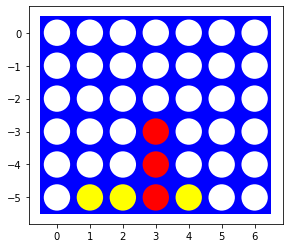

In [3]:
import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()
    
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board)

Implement helper functions for:

* The transition model $results(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

There is a smart way to represent a connect four game by John Tromp. His website can be found [here](https://tromp.github.io). Professor Herzberg is a professor at the Technische Hochschule Mittelhessen and wrote a great explanation of Tromp's code and published it on [github](https://github.com/denkspuren/BitboardC4/blob/master/BitboardDesign.md). 

It is based on storing a players move as a bitboard, which is nothing more than an unsigned 64 bit integer. The assignment of what position corresponds to what bit is shown below. With these positions, you can use bit operations to determine if a player has won. This mapping also make it easy to see if a column can take any more pieces and is a valid next move. He also writes about keeping track of the heights for each column, so that the state transition is fast. I took the psuedocode and implemented it in python below.

~~~

 6 13 20 27 34 41 48   55 62     Additional row
+---------------------+ 
| 5 12 19 26 33 40 47 | 54 61     top row
| 4 11 18 25 32 39 46 | 53 60
| 3 10 17 24 31 38 45 | 52 59
| 2  9 16 23 30 37 44 | 51 58
| 1  8 15 22 29 36 43 | 50 57
| 0  7 14 21 28 35 42 | 49 56 63  bottom row
+---------------------+
~~~

Since this format is very different than how it is stored above, I created functions to convert to and from the bitboard format. Using numba JIT compilation, I'm able to achieve a 5x speedup over the python native implementation. I also added the mean twist to all the different functions to make it work with the rules of the game.

In [67]:
from numba import njit

HEIGHT = np.uint64(6)
WIDTH = np.uint64(7)

CAN_USE_MEAN_MOVES = True
PLAYER_ONE_CAN_USE_MEAN_MOVES = False
PLAYER_TWO_CAN_USE_MEAN_MOVES = True

# Pre computed stuff based on formuals from John Tromp
H1 = np.uint64(HEIGHT+1)
H2 = np.uint64(HEIGHT+2)
SIZE1 = np.uint64(H1*WIDTH)
COL1 = np.uint64((np.uint64(1)<<H1)-np.uint64(1))
ALL1 = np.uint64((np.uint64(1)<<SIZE1)-np.uint64(1))
BOTTOM = np.uint64(ALL1 / COL1) 
TOP  = (BOTTOM << HEIGHT)
FULL = (BOTTOM << (HEIGHT-np.uint64(1)))

def make_bitboards():
    return np.array([np.uint64(0), np.uint64(0)])

@njit()
def make_bitboard_heights():
    heights = np.zeros(shape=WIDTH, dtype=np.uint64)
   
    for i in range(WIDTH):
        heights[i] = i*H1

    return heights

@njit()
def shift_pieces_down(boards, index, col):
    starting_heights = make_bitboard_heights()
    old_col_starting_height = starting_heights[col]

    # Get all the values for this column
    column = COL1 << old_col_starting_height
    curr_column_values = boards[index] & column

    # Clear them all
    boards[index] ^= curr_column_values

    # Clear out the one we pushed off the board
    curr_column_values &= ~(np.uint64(1) << old_col_starting_height)

    # Set them to the shifted version
    boards[index] ^= curr_column_values >> np.uint64(1)


@njit()
def make_normal_bitboard_move(boards, heights, counter, col):
    # Using the column, shift it to the right position
    update = np.uint64(1) << heights[col]

    # Keep track of the height for next time
    heights[col] += 1

    # Set this bit on the board
    boards[counter & 1] ^= update


@njit()
def make_mean_bitboard_move(boards, heights, counter, old_col, new_col):
    # Shift both boards down in that column
    shift_pieces_down(boards, 0, old_col)
    shift_pieces_down(boards, 1, old_col)
    heights[old_col] -= 1

    # Place the piece in the old column
    # Note we shift counter since its an opponent piece
    make_normal_bitboard_move(boards, heights, int(not (counter & 1)), new_col)

@njit()
def make_move(boards, heights, counter, move):
    if(move < 10):
        make_normal_bitboard_move(boards, heights, counter & 1, move-1)
    else:
        from_col = move // 10
        to_col = move % 10
        make_mean_bitboard_move(boards, heights, counter & 1, from_col-1, to_col-1)


@njit()
def get_actions(boards, heights, counter):
    moves = []

    for col in range(WIDTH):
        if isplayable_normal(heights, col):
            moves.append(col+1)
    
    if not CAN_USE_MEAN_MOVES:
        return moves
    
    if (counter & 1) == 0:
        if not PLAYER_ONE_CAN_USE_MEAN_MOVES: 
            return moves
    else:
        if not PLAYER_TWO_CAN_USE_MEAN_MOVES:
            return moves
    
    for start in range(WIDTH):
        for end in range(WIDTH):
            if start == end:
                continue
        
            if isplayable_mean(boards, heights, counter, start, end):
                num = ((start+1)*10) + (end+1)
                moves.append(num)

    return moves

@njit()
def is_full(boards):
    return FULL == (FULL & (boards[0] | boards[1]))

@njit()
def utility(boards):
    if is_bitboard_win(boards[0]):
        return 1
    if is_bitboard_win(boards[1]):
        return -1
    if is_full(boards):
        return 0
        
    return None

@njit()
def is_bitboard_win(board):
    # diagonal \
    diag1 = board & (board >> HEIGHT)

    # diagonal /
    diag2 = board & (board >> H2)

    # horizontal
    hori = board & (board >> H1)

    # vertical
    vert = board & (board >> np.uint64(1))

    return ((diag1 & (diag1 >> 2*HEIGHT)) |
          (hori & (hori >> 2*H1)) |
          (diag2 & (diag2 >> 2*H2)) |
          (vert & (vert >> 2))) != 0

@njit()
def isplayable_normal(heights, column):
    return (TOP & (np.uint64(1) << heights[column])) == 0


@njit()
def isplayable_mean(boards, heights, counter, from_col, end_col):
    other_board = int(not (counter & 1))

    pos = np.uint64(1) << (np.uint64(from_col)*H1)
    if (boards[other_board] & pos) == 0:
        return False
    
    return isplayable_normal(heights, end_col)


def class_board_to_bitboards(classboard):
    boards = make_bitboards()
    heights = make_bitboard_heights()

    for row in range(int(HEIGHT)-1, -1, -1):
        for col in range(WIDTH):
            cpiece = classboard[row][col]
            if cpiece == 1:
                make_normal_bitboard_move(boards, heights, 0, col)
            if cpiece == -1:
                make_normal_bitboard_move(boards, heights, 1, col)

    return boards, heights


def bitboards_to_class_board(boards):
    red_board = boards[0]
    yellow_board = boards[1]

    classboard = np.zeros(shape=(HEIGHT, WIDTH), dtype=np.int32)

    for row in range(HEIGHT):
        for col in range(7):
            bit = np.uint64(1) << (np.uint8(H1*col)+np.uint64(row))

            # If there is piece there, update class board
            if (red_board & bit) != 0:
                classboard[int(HEIGHT)-row-1][col] = 1

            # Same but with other board
            if (yellow_board & bit) != 0:
                classboard[int(HEIGHT)-row-1][col] = -1

    return classboard


IndentationError: expected an indented block (2297067414.py, line 116)

In [5]:
boards = make_bitboards()
heights = make_bitboard_heights()

isplayable_mean(boards, heights, 0, 0, 2)


False

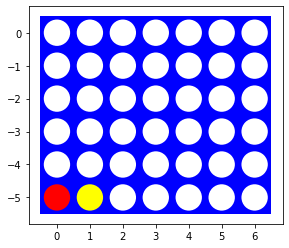

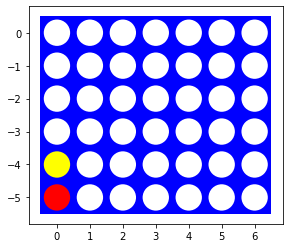

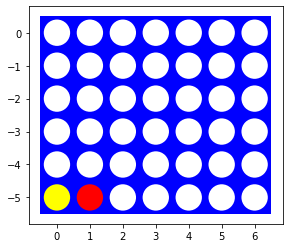

In [6]:
boards = make_bitboards()
heights = make_bitboard_heights()

make_move(boards, heights, 0, 1)
make_move(boards, heights, 1, 2)

classboard = bitboards_to_class_board(boards)
visualize(classboard)

make_move(boards, heights, 2, 21)

classboard = bitboards_to_class_board(boards)
visualize(classboard)

make_move(boards, heights, 3, 12)

classboard = bitboards_to_class_board(boards)
visualize(classboard)

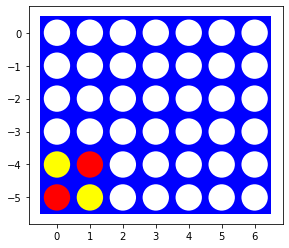

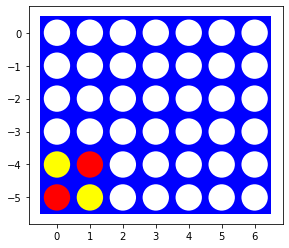

In [7]:
boards = make_bitboards()
heights = make_bitboard_heights()

make_move(boards, heights, 0, 1)
make_move(boards, heights, 1, 2)
make_move(boards, heights, 2, 2)
make_move(boards, heights, 3, 1)

classboard = bitboards_to_class_board(boards)
visualize(classboard)

boards, heights = class_board_to_bitboards(classboard)
visualize(classboard)


Moves on empty board:  [1, 2, 3, 4, 5, 6, 7]
Moves with one piece:  [1, 2, 3, 4, 5, 6, 7]


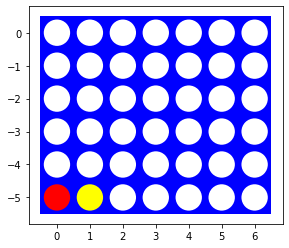

Moves with one piece:  [1, 2, 3, 4, 5, 6, 7]


In [8]:
boards = make_bitboards()
heights = make_bitboard_heights()

print('Moves on empty board: ', get_valid_moves(boards, heights, 0))

make_move(boards, heights, 0, 1)

print('Moves with one piece: ', get_valid_moves(boards, heights, 1))

make_move(boards, heights, 1, 2)

classboard = bitboards_to_class_board(boards)
visualize(classboard)

print('Moves with one piece: ', get_valid_moves(boards, heights, 0))



Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action.

In [49]:
import random

def random_agent(boards, heights, counter):
    #if counter == 0:
    #    return 4

    moves = get_valid_moves(boards, heights, counter)

    if len(moves) == 0:
        return None
        
    move = np.random.choice(moves, size=1)[0]
    return move

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how ranom agents can play against each other.

How often does each player win? Is the result expected?

In [61]:
def play(red, yellow, N = 100):
    """Let two agents play each other N times. x starts. x and y are agent functions that 
    get the board as the percept and return their next action."""
    results = {'red': 0, 'yellow': 0, 'd': 0}
    
    num_moves_to_finish = []
    funcs = [red, yellow]

    for _ in range(N):
        boards = make_bitboards()
        heights = make_bitboard_heights()

        for move_num in range(100):
            move = funcs[move_num & 1](boards, heights, move_num)
            if move is None:
                results['d'] += 1
                break

            make_move(boards, heights, move_num, move)
            
            if is_bitboard_win(boards[0]):
                results['red'] += 1
                num_moves_to_finish.append(move_num)
                break

            if is_bitboard_win(boards[1]):
                results['yellow'] += 1
                num_moves_to_finish.append(move_num)
                break
        
        if move_num == 99:
            results['d'] += 1
    
    return results, num_moves_to_finish

In [65]:
results, num_moves_to_finish = play(random_agent, random_agent, N = 10_000)
results

{'red': 9826, 'yellow': 174, 'd': 0}

(array([1.160e+03, 2.260e+03, 2.190e+03, 2.286e+03, 1.080e+03, 7.360e+02,
        2.320e+02, 4.400e+01, 1.100e+01, 1.000e+00]),
 array([ 6. ,  9.6, 13.2, 16.8, 20.4, 24. , 27.6, 31.2, 34.8, 38.4, 42. ]),
 <BarContainer object of 10 artists>)

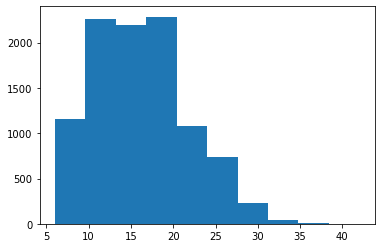

In [66]:
plt.hist(num_moves_to_finish)

## Task 3: Minimax Search with Alpha-Beta Pruning [3 points]

### Implement the search starting from a given board and specifying the player.

You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).


__Note:__ The game tree for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$).

In [8]:
import math 

# global variables
DEBUG = 1 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def alpha_beta_search(board, player = 'x'):
    """start the search."""
    global DEBUG, COUNT
    COUNT = 0
    
    value, move = max_value_ab(board, player, -math.inf, +math.inf)
    
    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}") 
    
    return { "move": move, "value": value }

def max_value_ab(state, player, alpha, beta):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1
       
    # return utility of state is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: print("max: " + str(state) + str([alpha, beta, v]) ) 
    if v is not None: return v, None
        
    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in get_actions(state):
        v2, a2 = min_value_ab(result(state, player, a), player, alpha, beta)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta: return v, move
    
    return v, move

def min_value_ab(state, player, alpha, beta):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1
    
    # return utility of state is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: print("min: " + str(state) + str([alpha, beta, v]) ) 
    if v is not None: return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in get_actions(state):
        v2, a2 = max_value_ab(result(state, other(player), a), player, alpha, beta)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: return v, move
    
    return v, move

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [9]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [10]:
# Your code/ answer goes here.

### Move ordering

Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [11]:
# Your code/ answer goes here.

### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

In [12]:
# Your code/ answer goes here.

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [13]:
# Your code/ answer goes here.

## Task 4: Heuristic Alpha-Beta Tree Search [3 points] 

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [14]:
# Your code/ answer goes here.

### Cutting off search 

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [15]:
# Your code/ answer goes here.

Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

In [16]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [17]:
# Your code/ answer goes here.

### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [18]:
# Your code/ answer goes here.

## Tournament task [+ 1 to 5 bonus point will be assigned separately]

Find another student and let your best agent play against the other student's best player. You are allowed to use any improvements you like as long as you code it yourself. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search (see [tic-tac-toe-example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_pure_monte_carlo_search.ipynb)) and investigate how this search performs on the test boards that you have used above. 

In [19]:
# Your code/ answer goes here.

### Best First Move

How would you determine what the best first move for a standard board ($6 \times 7$) is? You can use Pure Monte Carlo Search or any algorithms that you have implemented above.

In [20]:
# Your code/ answer goes here.